# Analysis of Equity Market Returns: Part 1

I will begin this research by using some of my newly aquire python data science skills to analyze the nature of stock market returns. This analysis will be focused on the distribution of the returns as compared to first the normal distribution. My initial hypothesis is that stock market returns are not normally distributed. This project encorporates many statistical concepts, for which brief descriptions will be given for the justification of use, however, proofs or detailed descriptions will not be given because of the scope of this project. The focuse is on the code, computations, procedures, and product rather than the underlying math.

In [80]:
# Importing the libraries I anticipate using
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import pandas_datareader.data as web
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import datetime
import scipy.stats as stats
%matplotlib inline

## Gathering Data

I will first begin by importing a list of securities currently listed on the NYSE and NASDAQ exchanges.

In [81]:
nasdaq_filepath = '/Users/kennypotts/Desktop/Personal Courses/QuantPython/jNotes/practiceDataSets/nasdaqCompanies.csv'
nyse_filepath = '/Users/kennypotts/Desktop/Personal Courses/QuantPython/jNotes/practiceDataSets/nyse_companies.csv'
nasdaq_comps_data = pd.read_csv(nasdaq_filepath)
nyse_comps_data = pd.read_csv(nyse_filepath)

In [82]:
nasdaq_comps_data.head()

,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,PIH,"1347 Property Insurance Holdings, Inc.",7.65,4.558532e+07,n/a,2014,Finance,Property-Casualty Insurers,http://www.nasdaq.com/symbol/pih,NaN
1,FLWS,"1-800 FLOWERS.COM, Inc.",10.8,7.050422e+08,n/a,1999,Consumer Services,Other Specialty Stores,http://www.nasdaq.com/symbol/flws,NaN
2,FCCY,1st Constitution Bancorp (NJ),17.35,1.385102e+08,n/a,n/a,Finance,Savings Institutions,http://www.nasdaq.com/symbol/fccy,NaN
3,SRCE,1st Source Corporation,44.2,1.143708e+09,n/a,n/a,Finance,Major Banks,http://www.nasdaq.com/symbol/srce,NaN
4,VNET,"21Vianet Group, Inc.",7.05,4.071372e+08,57749958,2011,Technology,"Computer Software: Programming, Data Processing",http://www.nasdaq.com/symbol/vnet,NaN


In [83]:
nyse_comps_data.head()

,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,DDD,3D Systems Corporation,13.38,1.503373e+09,n/a,n/a,Technology,Computer Software: Prepackaged Software,http://www.nasdaq.com/symbol/ddd,NaN
1,MMM,3M Company,178.41,1.073076e+11,n/a,n/a,Health Care,Medical/Dental Instruments,http://www.nasdaq.com/symbol/mmm,NaN
2,WBAI,500.com Limited,15.25,6.328454e+08,n/a,2013,Consumer Services,Services-Misc. Amusement & Recreation,http://www.nasdaq.com/symbol/wbai,NaN
3,WUBA,58.com Inc.,27.94,4.043012e+09,n/a,2013,Technology,"Computer Software: Programming, Data Processing",http://www.nasdaq.com/symbol/wuba,NaN
4,AHC,A.H. Belo Corporation,6.3,1.365604e+08,n/a,n/a,Consumer Services,Newspapers/Magazines,http://www.nasdaq.com/symbol/ahc,NaN


In [84]:
print('number of NASDAQ companies in data: ',len(nasdaq_comps_data))
print('number of NYSE companies in data: ',len(nyse_comps_data))

number of NASDAQ companies in data:  3204
number of NYSE companies in data:  3164


In [85]:
nonADR_nasdaq = nasdaq_comps_data[nasdaq_comps_data.IPOyear == 'n/a']
nonADR_nyse = nyse_comps_data[nyse_comps_data.IPOyear == 'n/a']

nyse_stocks = nonADR_nyse.loc[:,['Symbol','Name','MarketCap','IPOyear','Sector']]
nasdaq_stocks = nonADR_nasdaq.loc[:,['Symbol','Name','MarketCap','IPOyear','Sector']]

print(nyse_stocks.head())
print(nasdaq_stocks.head())

  Symbol                    Name     MarketCap IPOyear             Sector
0    DDD  3D Systems Corporation  1.503373e+09     n/a         Technology
1    MMM              3M Company  1.073076e+11     n/a        Health Care
4    AHC   A.H. Belo Corporation  1.365604e+08     n/a  Consumer Services
7    AIR               AAR Corp.  1.150710e+09     n/a      Capital Goods
8    AAN      Aaron&#39;s,  Inc.  2.326135e+09     n/a         Technology
   Symbol                           Name     MarketCap IPOyear  \
2    FCCY  1st Constitution Bancorp (NJ)  1.385102e+08     n/a   
3    SRCE         1st Source Corporation  1.143708e+09     n/a   
8    EGHT                        8x8 Inc  1.294889e+09     n/a   
9    AVHI                A V Homes, Inc.  3.667644e+08     n/a   
11   AAON                     AAON, Inc.  1.754112e+09     n/a   

              Sector  
2            Finance  
3            Finance  
8   Public Utilities  
9      Capital Goods  
11     Capital Goods  


 I am unsure whether I will use this data, but it seems to have some useful information in it. From the data there is no way to be sure whether a company is an [ETF](https://en.wikipedia.org/wiki/Exchange-traded_fund). Ideally I would eliminate all ETFs because they are just groups of individual stocks, which I am more interested in. Analyzing an ETF may show biased or overlapping results. I have found another data source which shows whether a company is an ETF.

The following data was found [here](http://www.nasdaqtrader.com/trader.aspx?id=symboldirdefs) and is updated daily. So far, I have been unable to find a list of companies that are no longer listed (used to be listed). This would be beneficial because it would eliminate [survivorship bias](https://en.wikipedia.org/wiki/Survivorship_bias) from my analysis. Quantopian has data for all stock from 2002 forward, including those no longer listed. However, I will try to do some of this analysis here in the jupyter notebook with other data because it is good practice to be able to pull data from an online source and manually manipulate it.

In [86]:
nasdaq_listed = pd.read_csv("ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqlisted.txt",sep='|')
nasdaq_listed.head()

,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares
0,AAAP,Advanced Accelerator Applications S.A. - Ameri...,Q,N,N,100.0,N,N
1,AAL,"American Airlines Group, Inc. - Common Stock",Q,N,N,100.0,N,N
2,AAME,Atlantic American Corporation - Common Stock,G,N,N,100.0,N,N
3,AAOI,"Applied Optoelectronics, Inc. - Common Stock",G,N,N,100.0,N,N
4,AAON,"AAON, Inc. - Common Stock",Q,N,N,100.0,N,N


In [87]:
other_listed = pd.read_csv("ftp://ftp.nasdaqtrader.com/symboldirectory/otherlisted.txt",sep='|')
other_listed.head()

,ACT Symbol,Security Name,Exchange,CQS Symbol,ETF,Round Lot Size,Test Issue,NASDAQ Symbol
0,A,"Agilent Technologies, Inc. Common Stock",N,A,N,100.0,N,A
1,AA,Alcoa Corporation Common Stock,N,AA,N,100.0,N,AA
2,AAC,"AAC Holdings, Inc. Common Stock",N,AAC,N,100.0,N,AAC
3,AADR,AdvisorShares Dorsey Wright ADR ETF,P,AADR,Y,100.0,N,AADR
4,AAMC,Altisource Asset Management Corp Com,A,AAMC,N,100.0,N,AAMC


In [88]:
print('Number of NASDAQ listed securities: ', len(nasdaq_listed))
print('Number of securities listed on other exchnages: ', len(other_listed))

Number of NASDAQ listed securities:  3176
Number of securities listed on other exchnages:  5179


## Storing Data

Although these DataFrames are not too large, it is good practice in data science to save large objects or data sets either by [pickling](https://docs.python.org/2/library/pickle.html) (serialization) or in the HDF5 format which can be done with pandas. This is crucial for large data sets and classifiers or models that have been trained/fit to data sets.

In [89]:
# Storing using HDF5 though pands
store = pd.HDFStore('project_data.h5')
store['nyse_comps_data'] = nyse_comps_data
store['nasdaq_comps_data'] = nasdaq_comps_data
store['nasdaq_listed'] = nasdaq_listed
store['other_listed'] = other_listed

/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['Symbol', 'Security Name', 'Market Category', 'Test Issue', 'Financial Status', 'ETF', 'NextShares']]

  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['ACT Symbol', 'Security Name', 'Exchange', 'CQS Symbol', 'ETF', 'Test Issue', 'NASDAQ Symbol']]

  exec(code_obj, self.user_global_ns, self.user_ns)


The data can now be retreived using dictionary like syntax.

In [90]:
store['nasdaq_listed'].head(2)

,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares
0,AAAP,Advanced Accelerator Applications S.A. - Ameri...,Q,N,N,100.0,N,N
1,AAL,"American Airlines Group, Inc. - Common Stock",Q,N,N,100.0,N,N


In [91]:
store.close()
store.is_open

False

Another option would have been to pickle the DataFrames manually:

In [92]:
import pickle

In [93]:
pickle.dump(nasdaq_listed, open('nasdaq_listed.p','wb'))
pickle.dump(other_listed, open('other_listed.p','wb'))

In [94]:
unpickled_nasdaq_listed = pickle.load(open('nasdaq_listed.p', 'rb'))
unpickled_nasdaq_listed.head(2)

,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares
0,AAAP,Advanced Accelerator Applications S.A. - Ameri...,Q,N,N,100.0,N,N
1,AAL,"American Airlines Group, Inc. - Common Stock",Q,N,N,100.0,N,N


If needed, I will be using the HDF5 format to store large data from here on.

## Initial Cleaning

As stated earlier, I only wish to look at non ETF securities.

In [95]:
nasdaq_nonETF = nasdaq_listed[nasdaq_listed.ETF == 'N']
nasdaq_nonETF.head(2)

,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares
0,AAAP,Advanced Accelerator Applications S.A. - Ameri...,Q,N,N,100.0,N,N
1,AAL,"American Airlines Group, Inc. - Common Stock",Q,N,N,100.0,N,N


In [96]:
other_nonETF = other_listed[other_listed.ETF == 'N']
other_nonETF.head(2)

,ACT Symbol,Security Name,Exchange,CQS Symbol,ETF,Round Lot Size,Test Issue,NASDAQ Symbol
0,A,"Agilent Technologies, Inc. Common Stock",N,A,N,100.0,N,A
1,AA,Alcoa Corporation Common Stock,N,AA,N,100.0,N,AA


There is, however, one ETF that I am interested in, SPY. [SPY](http://finance.yahoo.com/quote/SPY?ltr=1) is an ETF that tracks the [S&P 500 Index](https://en.wikipedia.org/wiki/S%26P_500_Index) which is designed to follow the market as a whole. For this reason it is used as a common benchmark to compare too. I already know what it is and its symbol so I don't need to find it in the DataFrames.

It will be useful to make and store a list of securities to look at.

In [97]:
listed_securities = nasdaq_nonETF['Symbol'].values.tolist() + other_nonETF['ACT Symbol'].values.tolist()
print('listed_securities:')
print('Length = ', len(listed_securities))
print('head(5) = ', listed_securities[:5])
print('repeated values = ', len(listed_securities) !=  len(set(listed_securities)))

listed_securities:
Length =  6558
head(5) =  ['AAAP', 'AAL', 'AAME', 'AAOI', 'AAON']
repeated values =  False


Now I have a list of securities symbols to pull from. They are not in order, but this is not crucial because I will be pulling from the list randomly in order to get sample securities to look at. Market from the first data sets I got may be usefull so I will create a market cap dictionary.

The code below accomplishes this using pandas slicing syntax which eliminates the need for costly for loops.

In [98]:
market_cap_dict = {}
# NASDAQ Companies
for security in nasdaq_nonETF['Symbol'].values.tolist():
    market_cap = nasdaq_comps_data[nasdaq_comps_data.Symbol == security].MarketCap.values
    if len(market_cap) == 1:
        market_cap_dict[security] = market_cap[0]
            
#NYSE Companies
for security in other_nonETF['ACT Symbol'].values.tolist():
    market_cap = nyse_comps_data[nyse_comps_data.Symbol == security].MarketCap.values
    if len(market_cap) == 1:
        market_cap_dict[security] = market_cap[0]
            
# This process also elimintaes securities listed on exchnages other than NYSE and NASDAQ

In [99]:
len(market_cap_dict.keys())

5527

In [100]:
market_cap_sr = Series(list(market_cap_dict.values()),index=list(market_cap_dict.keys()), name='MarketCap')
market_cap_sr.head(3)

RWLK    4.900202e+07
YUME    1.227915e+08
CTX     3.096648e+09
Name: MarketCap, dtype: float64

I will store this new market cap pandas series.

In [101]:
store = pd.HDFStore('project_data.h5')
store['market_cap_sr'] = market_cap_sr
store.close()

## Pricing Data

Now that I have a list of securities, I am going to get some pricing data. Pandas has a great built in data reader, which I will use to get daily prices from [Yahoo! Finance](http://finance.yahoo.com/).

I will start by retrieving pricing data for my benchmark, SPY, for which Yahoo! Finance has data as early as Jan 1993.

In [102]:
# Start and end dates for pricing period
start = datetime.date(1993,1,1) # beginning of SPY data on yahoo
end = datetime.date.today() # Today's date
SPY_pricing = web.DataReader('SPY', 'yahoo',start, end)

Store the data as a csv so it can be reloaded.

In [103]:
SPY_pricing.to_csv('SPY_pricing.csv', sep=',')

Again, even better than csv is HDF5:

In [104]:
store = pd.HDFStore('project_data.h5')
store['SPY_pricing'] = SPY_pricing
store.close()

In [51]:
SPY_pricing.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1993-01-29,43.9687,43.9687,43.7500,43.9375,1003200,28.000838
1993-02-01,43.9687,44.2500,43.9687,44.2500,480500,28.199990
1993-02-02,44.2187,44.3750,44.1250,44.3437,201300,28.259704
1993-02-03,44.4062,44.8437,44.3750,44.8125,529400,28.558465
1993-02-04,44.9687,45.0937,44.4687,45.0000,531500,28.677956


It is fine if the start date is before the first date with data, it will just begin the DataFrame on the first available day.

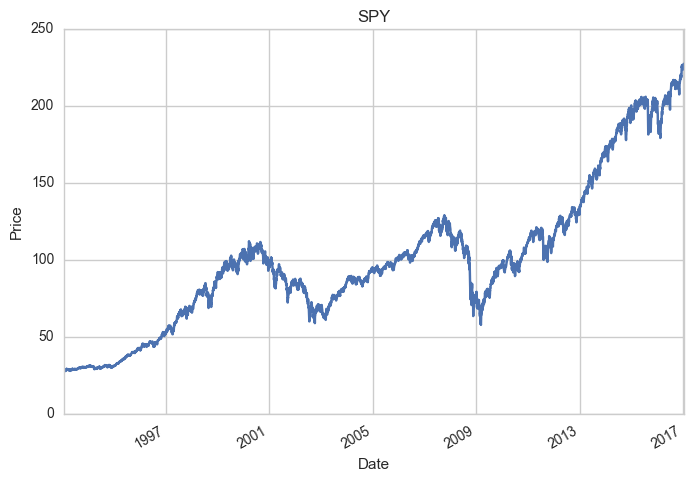

In [54]:
style.use('seaborn-notebook') # change the look of the plot, more appealing

SPY_pricing['Adj Close'].plot()
plt.ylabel('Price')
plt.title('SPY');

I will also get data for another asset to compare to SPY. I will choose randomly from the series of securities I have previously made.

In [137]:
sec_1 = np.random.choice(market_cap_sr.index) # numpy's random selection fucntion
sec_1_pricing = web.DataReader(sec_1, 'yahoo', start, end) # same start and end

In [138]:
print('Randomly Selected Security: ', sec_1)
sec_1_pricing.head(3)

Randomly Selected Security:  CB


,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1993-03-25,29.000001,29.124999,28.374999,28.625001,20047500,6.213560
1993-03-26,28.625001,29.124999,28.500000,28.749999,5826000,6.240693
1993-03-29,28.500000,28.749999,28.250001,28.374999,2249400,6.159293


In [146]:
holder = sec_1

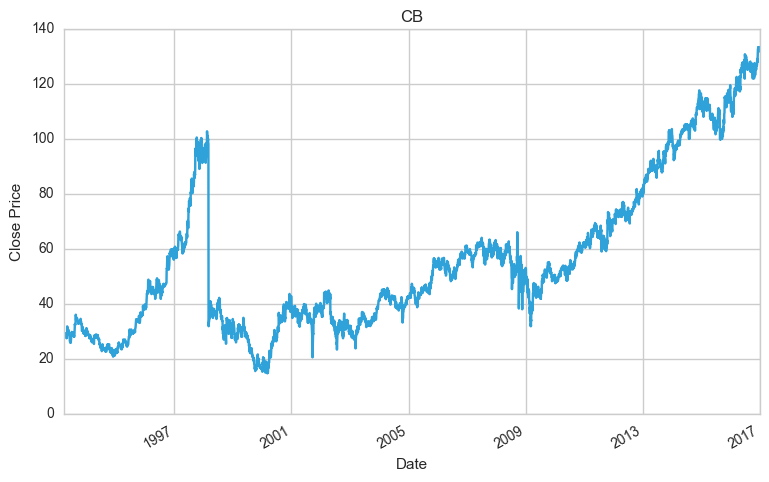

In [145]:
sec_1_pricing.Close.plot()
plt.ylabel('Close Price')
plt.title(sec_1);

### Adjusting for Stock Splits

Here I have plotted the close price. Notice that sometime around 1999 there is a large drop in the price. This is likely not a drop in price, but a [stock split](http://www.investopedia.com/terms/s/stocksplit.asp). Depending on the source of data, prices may or may not be adjusted for stock splits. Here, Yahoo! Finance has provided and `Adj Close` series which is the closing price adjusted for splits. It may be useful to also have the other prices also adjusted for splits for other future calculations. It would also be useful to have a function that can adjust for stock splits automatically. Here I will write a function that can adjust the DataFrame values according to the stock splits that took place.

In [147]:
def splitAdjust(d, ticker):
    """
    Retun split adjusted price data.
    
    Uses yahoo-actions data to determine when and how much stock plits were,
    if they have occured. The initial data given are adjusted for the splits,
    with the exception of the Adj Close and Volume which have already been adjusted.
    The adjusted prices are appended to a copu of the initial dataframe and returned.
    """
    data = d.copy()
    start = data.index[0]
    end = data.index[len(data.index)-1]
    actions = web.DataReader(ticker, 'yahoo-actions', start, end)
    splits = actions[actions.action == 'SPLIT']
    
    # Find the index and date of the split
    split_idxs = {i:x for i,x in enumerate(data.index.tolist()) if x in splits.index}
    columns = data.columns.tolist()
    
    # adjust for the splits
    for idx, date in split_idxs.items():
        for col in range(len(columns)):
            if columns[col] != 'Volume' and columns[col] != 'Adj Close':
                # adjust the prices of the shares
                data.iloc[:idx, col] = data.iloc[:idx, col]*splits.loc[date].value
    return data

Now to use the `splitAdjust` function to get adjusted prices and determine if the sudden change was in fact due to a stock split.

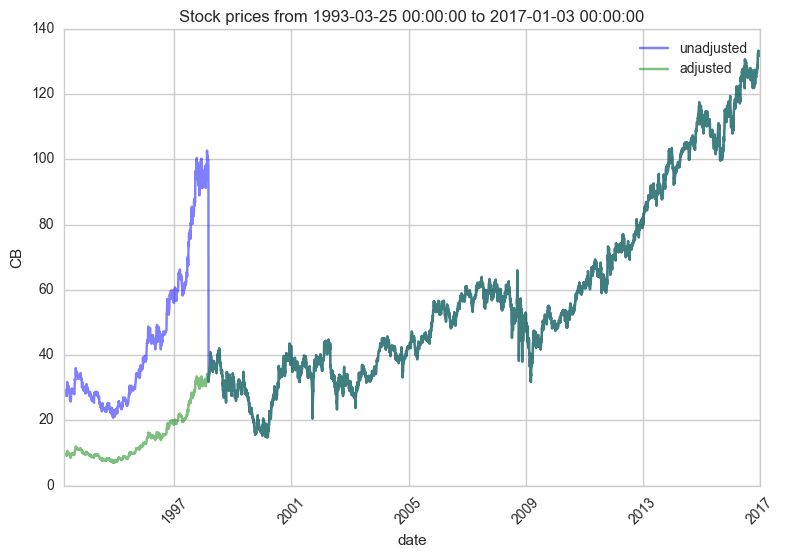

In [154]:
sec_1_adj_pricing = splitAdjust(sec_1_pricing, sec_1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sec_1_pricing.index, sec_1_pricing.Close, 'b-', alpha=0.5, label='unadjusted')
ax.plot(sec_1_adj_pricing.index, sec_1_adj_pricing.Close,'g-', alpha=0.5, label='adjusted')

plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('date')
ax.set_ylabel(sec_1)
ax.legend()
ax.set_title('Stock prices from {0} to {1}'.format(sec_1_pricing.index[0],sec_1_pricing.index[-1]));

## Analyzing Returns

It is difficult to compare asset prices because a large price in one asset may be comparatively small for another. This is because each asset has a different price. It is more useful to compare returns rather than prices. We can look at the daily return for period i, $r_{i}$, as the percent change in price from day $i-1$ to day $i$.

$$r_{i} = 1 - \frac{P_{i} - P_{i-1}}{P_{i-1}}$$

where $P_{i}$ is the price at the close of day $i$. This is a geometric calculation of returns because calculating the return over multiple periods requires multiplication. Consider the returns for periods $1-n$, written as $r_{1}, r_{2}, r_{3}, ..., r_{n}$, then to calculate the total return, $r$, over the we calculate:

$$r = (1 + r_{1})(1 + r_{2})(1 + r_{3})...(1 + r_{n})-1$$

Another way to measure returns is logarithmically, or **log returns**, which represent the rate of **continuous compounding** returns. The calculation:

$$r_{i} = ln\left(\frac{P_{i} - P_{i-1}}{P_{i-1}}\right)$$

This is very beneficial because due to the properties of logarithms, we can then calculate the return from period 1 to $n$, $r_{j}$, as

$$\sum_{j=1}^{n}r_{j} = r_{1} + r_{2} + ... + r_{n}$$

The returns are additive rather than multiplicative and therefore a logarithmic positive return of $k$ is negated by a logaritmic return of $-k$. This is not the case for geometric returns, e.g. $(1 + 1)(1 - \frac{1}{2}) = 1$, a $100\%$ return followed by a $-50\%$ return.

Because of their additive property, log returns are best to use when measuring normality. I will be **using log returns** for the my analysis of returns, and for now I will be using an **adjusted close** price unless otherwise stated.

In [155]:
# Calculating log returns
# drop the first value, it is NaN because pct_change requires 2 periods
SPY_returns = np.log(1 + SPY_pricing['Adj Close'].pct_change()[1:])
sec_1_returns = np.log(1 + sec_1_pricing['Adj Close'].pct_change()[1:])

In [156]:
SPY_returns.head(3)

Date
1993-02-01    0.007087
1993-02-02    0.002115
1993-02-03    0.010516
Name: Adj Close, dtype: float64

We can then plot the returns using a histogram.

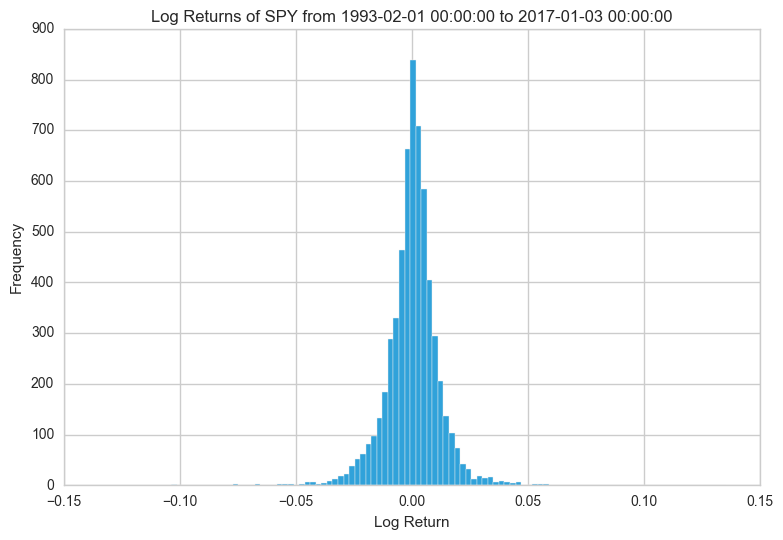

In [163]:
SPY_returns.hist(bins=100)
plt.title('Log Returns of SPY from {0} to {1}'.format(SPY_returns.index[0],SPY_returns.index[-1]))
plt.xlabel('Log Return')
plt.ylabel('Frequency');

We can compare the returns of SPY to those of another asset, for instance the randomly selected security `sec_1` for which I have already calculated the returns. It is first necessary to determine the time period over which to compare returns. One asset may have more data, which could make for a biased comparison. I will compare over the period in which both assets have data available. Pandas TimeStamps allow you to compare dates with the regular comparison operators.

For clearer visualization, it may help to normalize the histograms, i.e. the areas of the bars for both securities sum to 1.

In [171]:
# Assign names
SPY_returns.name = 'SPY'
sec_1_returns.name = sec_1

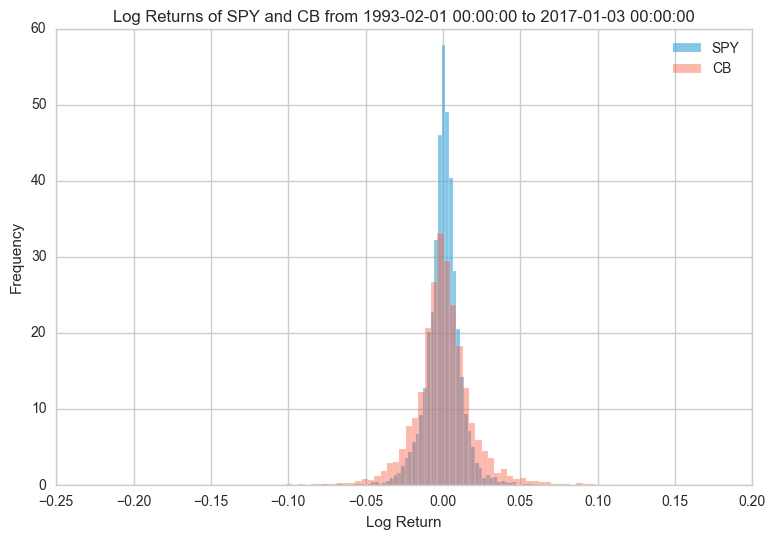

In [198]:
start = SPY_returns.index[0]

if sec_1_returns.index[0] > start:
    start = sec_1_returns.index[0]
    
plt.hist(SPY_returns[start:], bins=100, normed=True, stacked=True, alpha=0.6, label=SPY_returns.name)
plt.hist(sec_1_returns[start:], bins=100, normed=True, stacked=True, alpha=0.4, label=sec_1_returns.name)
# SPY_returns[start:].hist(bins=60, normed=True,alpha=0.6, label=SPY_returns.name)
# sec_1_returns[start:].hist(bins=60, normed=True, alpha=0.4, label=sec_1_returns.name)
plt.title('Log Returns of {0} and {1} from {2} to {3}'
          .format(SPY_returns.name, sec_1_returns.name, SPY_returns.index[0], SPY_returns.index[-1]))
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.legend();

The histogram shows the potential distribution of the returns for `sec_1` and SPY. It is not surprising that the returns of the SPY vary less than that of `sec_1`, but how can the difference be measured? Notice the difference in shape of the tails (edges of the distribution).

## Statistical Moments

Here I will introduce some comment metrics for describing distributions. Because the distributions shown above have been normalized, we can thing of them as [probability density functions](https://en.wikipedia.org/wiki/Probability_density_function), where the area underneath the distribution for any region represents the probability of that a random variable falls within that region.

### $1^{st}$ Moment: Mean

There are a few main types of means; arithmetic, harmonic, and geometric. All are measures of central tendency of data. I will be using the arithmetic mean. The mean for the whole population is usually called $\mu$ and it is calculated as the sum of the observations divided by the number of observations:

$$\mu = \frac{\sum_{i=1}^N X_i}{N}$$

where $X_1, X_2, \ldots , X_N$ are our observations. The sample mean, from a sample of the populetion, is called $\overline{X}$. There are other measures of centrality such as the median and mode, but I will only be using the mean in my work unless otherwise stated. The mean is considered the first statistical moment.

### $2^{nd}$ Moment: Variance

The population variance is usually referred to as $\sigma^{2}$ and is defined as the average squared deviation from the mean:

$$ \sigma^{2} = \frac{\sum_{i=1}^{n} (X_i - \mu)^{2}}{n} $$

Then the standard deviation, $\sigma$ is defined as the square root of the variance. I will mainly be using the standard deviation because it is in the same units as the observations. The sample variance and stadard deviation are refered to as $s^{2}$ and $s$ respectively and are calculated with $n-1$ in the denominator instead of just $n$, and the sample the mean $\overline{X}$ instead of $\mu$.

### Normal Distribution

Before introducing the third and fourth moments, I will introduce the normal distribution, whitch is a focus of this project. The normal distribution is a probability distribution and is widely used in statistics and finance. We defined the probability density function of the normal distribution with a mean $\mu$ and standard deviation $\sigma$ as:

$$ f(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{(x - \mu)^{2}}{2 \sigma^{2}}} $$

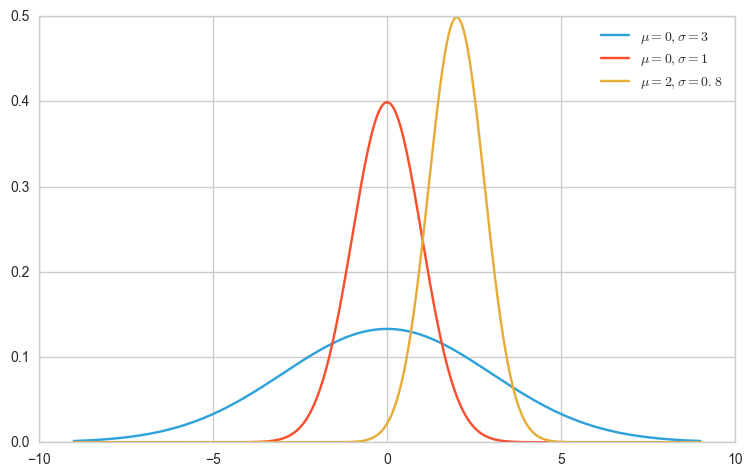

In [238]:
style.use('seaborn-notebook') # change the look of the plot, more appealing

# A normal distribution with a mean = 0 and std_dev = 3
x = np.linspace(-9,9,400)
normal_3 = stats.norm.pdf(x, loc=0, scale=3)

# A normal distribution with a mean = 0 and std_dev = 1
normal_1 = stats.norm.pdf(x, loc=0, scale=1)

# A normal distribution with a mean = 2 and std_dev = 0.5
normal_2 = stats.norm.pdf(x, loc=2, scale=0.8)

plt.plot(x, normal_3)
plt.plot(x, normal_1)
plt.plot(x, normal_2)
plt.legend(['$\mu=0, \sigma=3$','$\mu=0, \sigma=1$','$\mu=2, \sigma=0.8$']);

### $3^{rd}$ Moment: Skewness

Distributions do not have to be symmetric. A distribution may have a longer and fatter tail on the right side and not many large values on the left (negatively skewed), or vice versa (positively skewed) irrespective of the mean and variance. The sample skewness describes the symmetry of the distribution and is explicitly defined as:

$$S_K = \frac{n}{(n-1)(n-2)} \sum_{i=1}^n\left(\frac{(X_i - \overline{X})}{\sigma}\right)^{3}$$

Skew of the blue distribution:  -2.26008388849
Skew of the red distribution:  2.2600838884867054


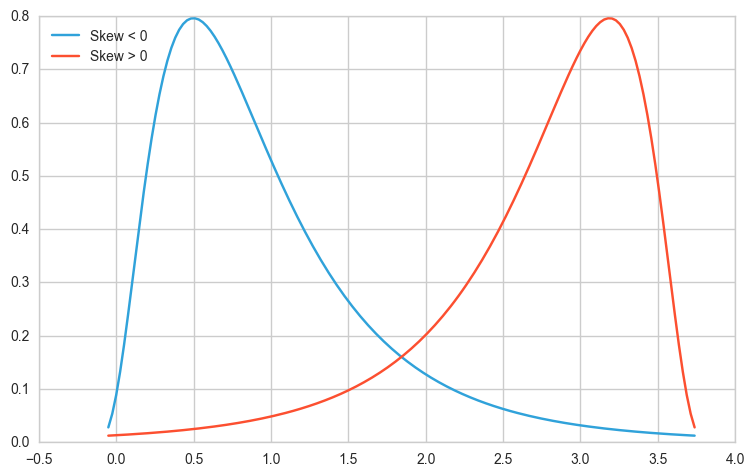

In [239]:
# usuing ppf, (percentage point function or inverse cdf, cumulative density function) to get x bounds
x = np.linspace(stats.lognorm.ppf(0.01, 0.6, loc=-0.3), stats.lognorm.ppf(0.99, 0.6, loc=-0.3), 150)

# Negatively skewed distribution
lognormal = stats.lognorm.pdf(x, 0.6, loc=-0.2)
plt.plot(x, lognormal, label='Skew < 0')

# Positively skewed
plt.plot(x, lognormal[::-1], label='Skew > 0')
plt.legend(loc='best');

print('Skew of the blue distribution: ', -stats.lognorm.stats(s=0.6, loc=-0.2, moments='s'))
print('Skew of the red distribution: ', stats.lognorm.stats(s=0.6, loc=-0.2, moments='s'))

### $4^{th}$ Moment: Kurtosis

Kurtosis is a measure of the shape of the deviation from the mean, and more specifically how the center and tails of the distribution act. For large enough values of n, kurtosis is calculated as:

$$K = \frac{1}{n}\frac{\sum_{i=1}^{n}(X-\overline{X})^{4})}{s^{4}}$$

for small values of n:

$$ K = \left ( \frac{n(n+1)}{(n-1)(n-2)(n-3)} \frac{\sum_{i=1}^n (X_i - \overline{X})^4}{s^4} \right ) $$

A normal distribution always has a kurtosis of 3.A deviation from 3 is called excess curtosis. We can subtract 3 from kurtosis to calculate excess kurtosis. For large enough values of n, excess kurtosis is calculated as:

$$K_{e} = \frac{1}{n}\frac{\sum_{i=1}^{n}(X-\overline{X})^{4})}{s^{4}} - 3$$

for small values of n:

$$ K_E = \left ( \frac{n(n+1)}{(n-1)(n-2)(n-3)} \frac{\sum_{i=1}^n (X_i - \overline{X})^4}{s^4} \right ) - \frac{3(n-1)^2}{(n-2)(n-3)} $$

A leptokurtic distribution has as kurtosis greater than 3, which means it has a very tall peak and fat tails as compaired to the normal distribution. A platykurtic distribution has as kurtosis less than 3, which means it has a very short peak and small tails as compaired to the normal distribution. A distribution with a kurtosis of 3, such as the normal distribution, is called mesokurtic. My initial hypothesis is that market returns are not normal, more specifically that they are leptokurtic; i.e. have fat tails and tall peaks.

More resources on skewness and kurtosis found [here](http://itl.nist.gov/div898/handbook/eda/section3/eda35b.htm).

Excess kurtosis of leptokurtic distribution:  3.0
Excess kurtosis of mesokurtic distribution:  0.0
Excess kurtosis of platykurtic distribution:  -0.5937628755982794


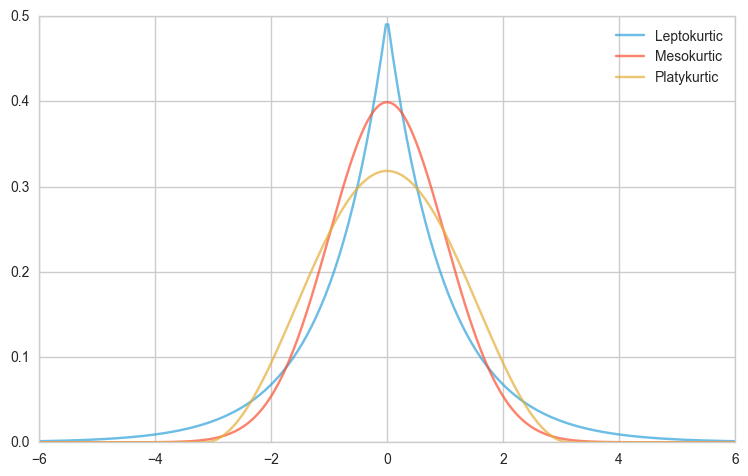

In [240]:
# Example distributions
x = np.linspace(-6,6, 300)
plt.plot(x, stats.laplace.pdf(x), alpha=0.7, label='Leptokurtic')
plt.plot(x, stats.norm.pdf(x), alpha=0.7, label='Mesokurtic')
plt.plot(x, stats.cosine.pdf(x), alpha=0.7, label='Platykurtic')
plt.legend()

print('Excess kurtosis of leptokurtic distribution: ', stats.laplace.stats(moments='k'))
print('Excess kurtosis of mesokurtic distribution: ', stats.norm.stats(moments='k'))
print('Excess kurtosis of platykurtic distribution: ', stats.cosine.stats(moments='k'));

Excess kurtosis of Laplace distribution: 3.0
Excess kurtosis of Normal distribution: 0.0
Excess kurtosis of Cosine distribution: -0.5937628755982794
Excess kurtosis of Poisson distribution: inf
Excess kurtosis of Powerlaw distribution: 46.446772758722936
Excess kurtosis of Rayleigh distribution: 0.24508930068763846
Excess kurtosis of Exponential distribution: 6.0
Excess kurtosis of Logistic distribution: 1.2


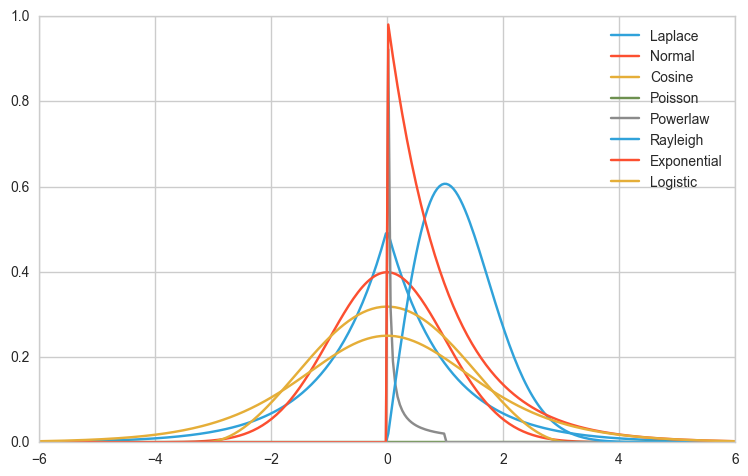

In [241]:
# Plot some Scipy.stats example distributions


plt.plot(x,stats.laplace.pdf(x), label='Laplace')
print('Excess kurtosis of Laplace distribution:', (stats.laplace.stats(moments='k')))
plt.plot(x, stats.norm.pdf(x), label='Normal')
print('Excess kurtosis of Normal distribution:', (stats.norm.stats(moments='k')))
plt.plot(x,stats.cosine.pdf(x), label='Cosine')
print('Excess kurtosis of Cosine distribution:', (stats.cosine.stats(moments='k')))
plt.plot(x,stats.poisson.pmf(x,mu=0), label='Poisson')
print('Excess kurtosis of Poisson distribution:', (stats.poisson.stats(moments='k',mu=0)))
plt.plot(x,stats.powerlaw.pdf(x,a=0.02), label='Powerlaw')
print('Excess kurtosis of Powerlaw distribution:', (stats.powerlaw.stats(moments='k',a=0.02)))
plt.plot(x,stats.rayleigh.pdf(x), label='Rayleigh')
print('Excess kurtosis of Rayleigh distribution:', (stats.rayleigh.stats(moments='k')))
plt.plot(x,stats.expon.pdf(x), label='Exponential')
print('Excess kurtosis of Exponential distribution:', (stats.expon.stats(moments='k')))
plt.plot(x,stats.logistic.pdf(x), label='Logistic')
print('Excess kurtosis of Logistic distribution:', (stats.logistic.stats(moments='k')))
plt.legend();

### SPY

======Mean====== 
 SPY: 0.00034598939334321, CB: 0.0005099980942797913
==Standard Dev== 
 SPY: 0.01177028466220026, CB: 0.02064193685469671
======Skew====== 
 SPY: -0.11847041132638117, CB: 0.23098399703419806
==Excess Kurt.== 
 SPY: 10.103338726822177, CB: 11.195696159272748


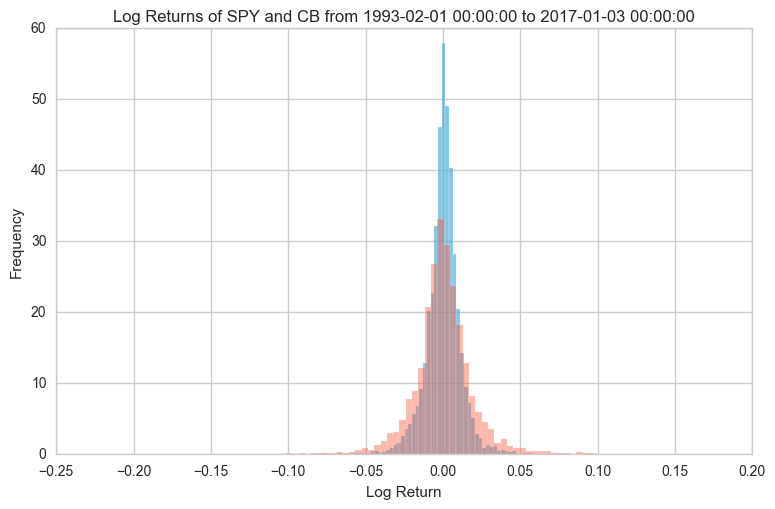

In [251]:
print('======Mean====== \n SPY: {0}, {1}: {2}'.format(np.mean(SPY_returns), sec_1, np.mean(sec_1_returns)))
print('==Standard Dev== \n SPY: {0}, {1}: {2}'.format(np.std(SPY_returns), sec_1, np.std(sec_1_returns)))
print('======Skew====== \n SPY: {0}, {1}: {2}'.format(stats.skew(SPY_returns), sec_1, stats.skew(sec_1_returns)))
# stats.kurtosis calcs excess kurtosis
print('==Excess Kurt.== \n SPY: {0}, {1}: {2}'.format(stats.kurtosis(SPY_returns), sec_1, stats.kurtosis(sec_1_returns)))

plt.hist(SPY_returns[start:], bins=100, normed=True, stacked=True, alpha=0.6, label=SPY_returns.name)
plt.hist(sec_1_returns[start:], bins=100, normed=True, stacked=True, alpha=0.4, label=sec_1_returns.name)

plt.title('Log Returns of SPY and {2} from {0} to {1}'.format(SPY_returns.index[0],SPY_returns.index[-1], sec_1))
plt.xlabel('Log Return')
plt.ylabel('Frequency');

For the SPY, the mean appears slightly positive. There is a slight negative skew, and very large positive excess kurtosis. For perspective I will overlay a normal distribution that has been fit to SPY (with the same mean and standard deviation), and normalized the SPY histogram to see how they compare.

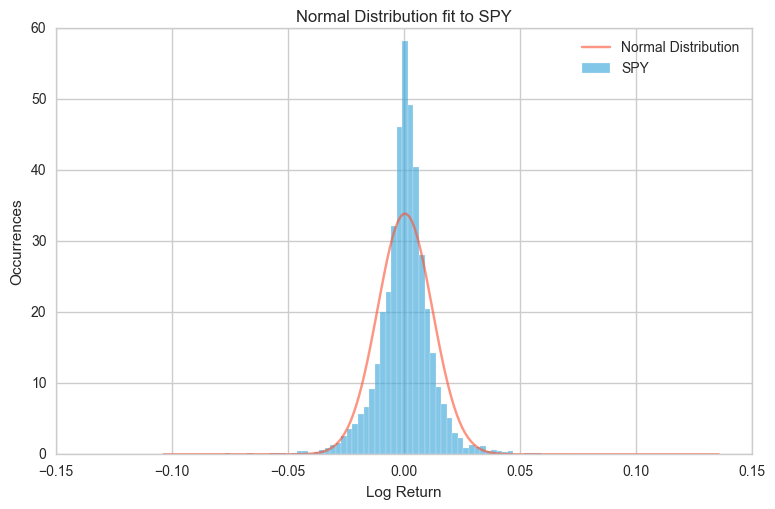

In [256]:
# set up x values
x = np.linspace(SPY_returns.min(), SPY_returns.max(), 200)

mu = np.mean(SPY_returns)
sigma = np.std(SPY_returns)
plt.hist(SPY_returns, bins=100, normed=True, stacked=True, alpha=0.6, label=SPY_returns.name)
plt.plot(x, stats.norm.pdf(x, loc=mu, scale=sigma), alpha=0.6, label='Normal Distribution')

plt.title('Normal Distribution fit to SPY')
plt.xlabel('Log Return')
plt.ylabel('Occurrences')
plt.legend();

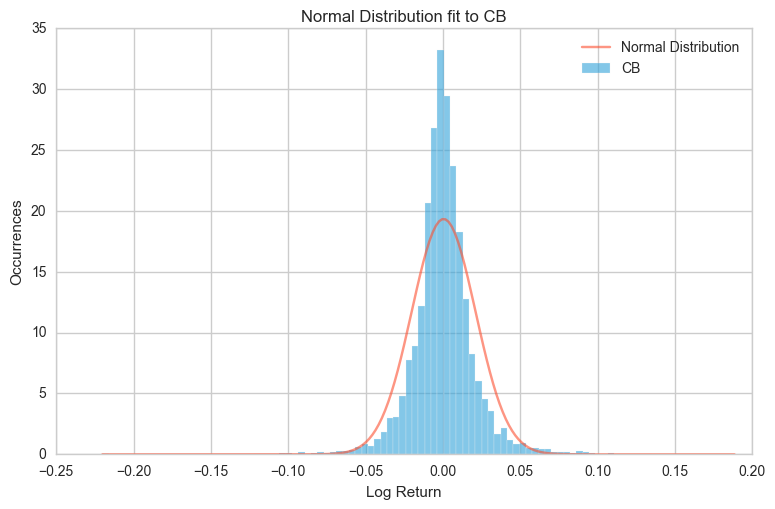

In [257]:
# set up x values
x = np.linspace(sec_1_returns.min(), sec_1_returns.max(), 200)

# parameter estimation
mu = np.mean(sec_1_returns)
sigma = np.std(sec_1_returns)

plt.hist(sec_1_returns, bins=100, normed=True, stacked=True, alpha=0.6, label=sec_1_returns.name)
plt.plot(x, stats.norm.pdf(x, loc=mu, scale=sigma), alpha=0.6, label='Normal Distribution')

plt.title('Normal Distribution fit to ' +sec_1)
plt.xlabel('Log Return')
plt.ylabel('Occurrences')
plt.legend();

I will pull another random security from my list of securities and repeat the procedure.

In [265]:
start = datetime.date(1993,1,1)
end = datetime.date.today()

sec_2 = np.random.choice(market_cap_sr.index) # numpy's random selection fucntion
sec_2_pricing = web.DataReader(sec_2, 'yahoo', start, end) # same start and end

sec_2_returns = np.log(1 + sec_2_pricing['Adj Close'].pct_change()[1:])

sec_2_returns.name = sec_2

JMPC  mean:  0.000239031409607
JMPC  standard deviation:  0.00876328693392
JMPC  skew:  -3.3594963791552033
JMPC  kurtosis:  46.84488213322666


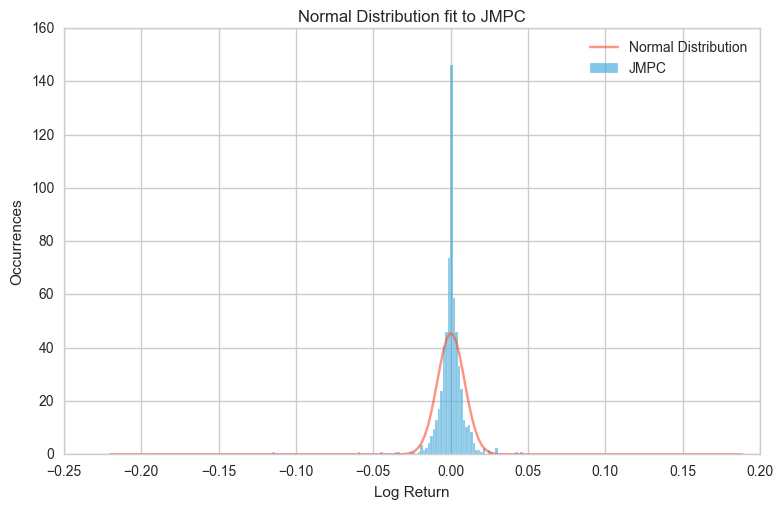

In [266]:
# set up x values
x = np.linspace(sec_1_returns.min(), sec_1_returns.max(), 200)

# parameter estimation
mu = np.mean(sec_2_returns)
sigma = np.std(sec_2_returns)

print(sec_2,' mean: ',mu)
print(sec_2,' standard deviation: ',sigma)
print(sec_2,' skew: ',stats.skew(sec_2_returns))
print(sec_2,' kurtosis: ',stats.kurtosis(sec_2_returns))

plt.hist(sec_2_returns, bins=100, normed=True, stacked=True, alpha=0.6, label=sec_2_returns.name)
plt.plot(x, stats.norm.pdf(x, loc=mu, scale=sigma), alpha=0.6, label='Normal Distribution')

plt.title('Normal Distribution fit to ' +sec_2)
plt.xlabel('Log Return')
plt.ylabel('Occurrences')
plt.legend();

## Quantifying Non-Normallity

Scipy.stats provides a few functions which test the null hypothesis that the population from which a set of data is drawn from exhibits a normal distribution.

Resource: [BAI, Ng, "Tests for Skewness, Kurtosis, and Normality
for Time Series Data" 2005](http://www.columbia.edu/~jb3064/papers/2005_Testing_skewness_kurtosis_and_normality_for_time_series_data.pdf)

### Skewness Test

We can test for normallity by producing a $Z$-score using the skewness of the distribution. This is exactly what `scipy.stats.skewtest` does.

We will test for normality of the log returns of SPY. The null hypothesis is that the distribution of returns is normal. We will use a significance level of $p=0.05$. This will be a two sided hypothesis test. If the test result is $p<0.05$ then we will reject the null hypothesis and accept the alternative hypothesis that the returns are non normally distributed.

In [282]:
# A function to visualize the z-scores
def visualize_z_score(score, cutoff, visual_mode=True):
    # params for generalization
    mu = 0
    sigma = 1

    # Set up the x axis
    x = np.linspace(-5,5,100)
    # Here's the normal distribution
    y = stats.norm.pdf(x,mu,sigma)
    
    fig, ax = plt.subplots(1,1, sharex=True)
    ax.plot(x,y, label='Standard Normal Distribution')

    # shade our rejection regions
    ax.fill_between(x, 0, y, where = x > stats.norm.ppf(1-(cutoff/2)), alpha=0.7)
    ax.fill_between(x, 0, y, where = x < stats.norm.ppf(cutoff/2), alpha=0.7)
    
    plt.vlines(score, 0, stats.norm.pdf(mu)*1.1, colors='r', linestyles='dashed', label='$Z$-score='+str(score))
    # plt.vlines(stats.norm.ppf(1-(cutoff/2)), mu, sigma, colors='r', linestyles='dashed')

    plt.title('Rejection Regions and $Z$-score')
    plt.xlabel('$\sigma$')
    plt.ylabel('Normal PDF')
    plt.legend(loc='best');

With a test stat of -3.7461121287529333 and p=0.0001795963404162073<0.05, we reject the null hypothesis


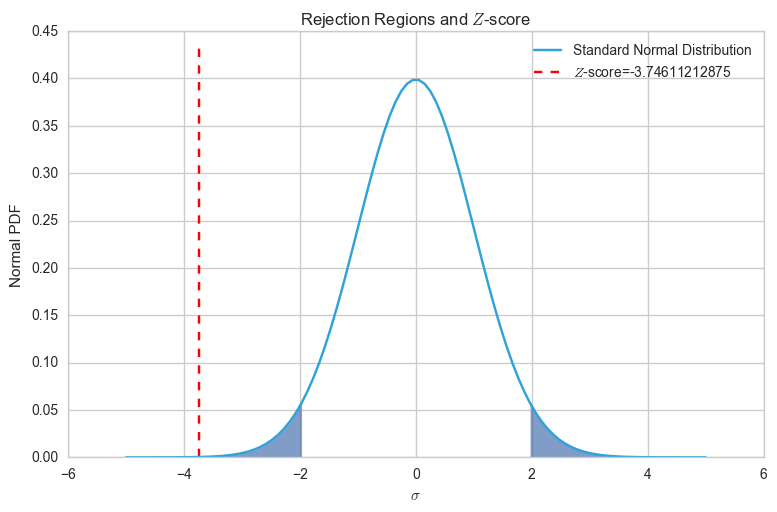

In [283]:
# for the SPY, test for normality using skewness
test_stat, p_value = stats.skewtest(SPY_returns)
cutoff = 0.05

if p_value < cutoff:
    print('With a test stat of {0} and p={1}<{2}, we reject the null hypothesis'.format(test_stat, p_value, cutoff))
else:
    print('With a test stat of {0} and p={1}>{2}, we fail to reject the null hypothesis'.format(test_stat, p_value, cutoff))
    
visualize_z_score(test_stat, cutoff)

We can repeat the test for another random asset and see the results.

In [284]:
start = datetime.date(1993,1,1)
end = datetime.date.today()

sec_3 = np.random.choice(market_cap_sr.index) # numpy's random selection fucntion
sec_3_pricing = web.DataReader(sec_3, 'yahoo', start, end) # same start and end

sec_3_returns = np.log(1 + sec_3_pricing['Adj Close'].pct_change()[1:])

sec_3_returns.name = sec_3

In [285]:
sec_3

'FATE'

With a test stat of 13.050275252097993 and p=6.331822489454215e-39<0.05, we reject the null hypothesis


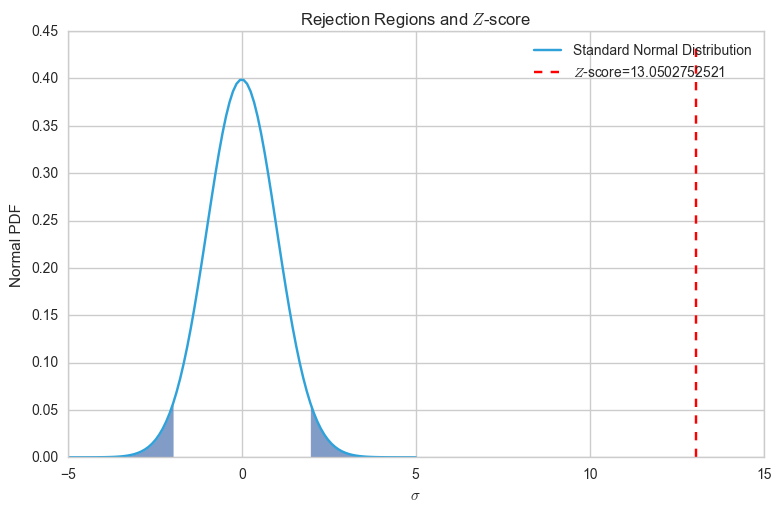

In [286]:
# sec_3 test for normality using skewness
test_stat, p_value = stats.skewtest(sec_3_returns)
cutoff = 0.05

if p_value < cutoff:
    print('With a test stat of {0} and p={1}<{2}, we reject the null hypothesis'.format(test_stat, p_value, cutoff))
else:
    print('With a test stat of {0} and p={1}>{2}, we fail to reject the null hypothesis'.format(test_stat, p_value, cutoff))
    
visualize_z_score(test_stat, cutoff)

### Kurtosis Test

We can test for normallity by producing a $Z$-score using the kurtosis of the distribution. This is exactly what `scipy.stats.kurtosistest` does.

We can repeat the same hypothesis test as before with the skewness test.

With a test stat of 12.360672333673367 and p=4.265739197263299e-35<0.05, we reject the null hypothesis


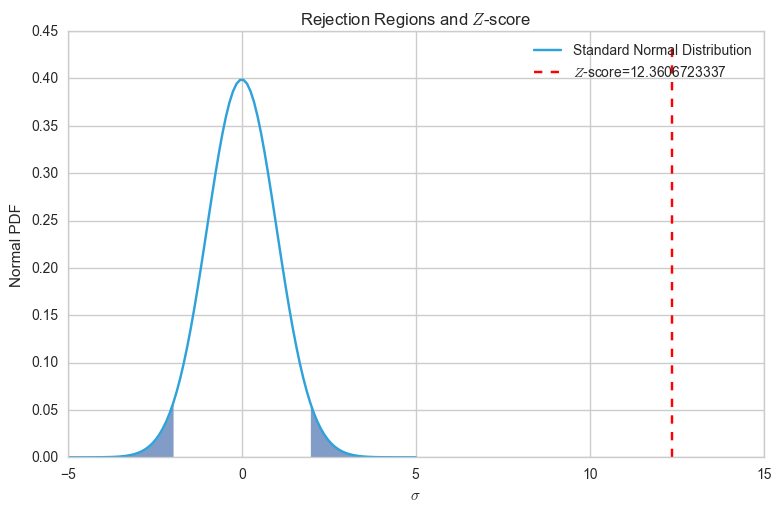

In [288]:
# for the SPY, test for normality using kurtosis
test_stat, p_value = stats.kurtosistest(sec_3_returns)
cutoff = 0.05

if p_value < cutoff:
    print('With a test stat of {0} and p={1}<{2}, we reject the null hypothesis'.format(test_stat, p_value, cutoff))
else:
    print('With a test stat of {0} and p={1}>{2}, we fail to reject the null hypothesis'.format(test_stat, p_value, cutoff))
    
visualize_z_score(test_stat, cutoff)

### Jarque-Bera Test

The [Jarque-Bera test](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test) tests for normality by using both the skewness and the excess kurtosis. It uses a $JB$ statistc which is calculated as:

$$JB={\frac  {n-k+1}{6}}\left(S^{2}+{\frac  14}(C-3)^{2}\right)$$

where $S$ is the sample skewness, $C$ is the sample kurtosis, and $k$ is the number of regressors. The $JB$ asymptotically has a $\chi^2$ distribution with 2 degrees of freedom. As a result, `scipy.stats.jarque_bera` recommends using it with greater than 2,000 samples.

Reference:

[Jarque, C. and Bera, A. (1980) "Efficient tests for normality,
       homoscedasticity and serial independence of regression residuals",
       6 Econometric Letters 255-259.](http://www.columbia.edu/~jb3064/papers/2005_Testing_skewness_kurtosis_and_normality_for_time_series_data.pdf)

In [290]:
from statsmodels.stats.stattools import jarque_bera

In [307]:
# A function to visualize the schi-squared dist. scores
def visualize_chi_squared(score, cutoff, dof, visual_mode=True):

    # Set up the x axis
    x = np.linspace(0,10,100)
    # Here's the normal distribution
    y = stats.chi2.pdf(x, df = dof)
    
    fig, ax = plt.subplots(1,1, sharex=True)
    ax.plot(x,y, label='$\chi^2$ Distribution, '+str(dof)+' Degrees of Freedom')

    # shade our rejection regions
    ax.fill_between(x, 0, y, where = x > stats.chi2.ppf(1-(cutoff), df=dof), alpha=0.7)
    
    plt.vlines(score, ymin=0, ymax=np.max(y)*1.1,colors='r', linestyles='dashed', label='score='+str(score))
    # plt.vlines(stats.norm.ppf(1-(cutoff/2)), mu, sigma, colors='r', linestyles='dashed')

    plt.title('Rejection Regions and score')
    plt.ylabel('Density')
    if score > 10:
        plt.xscale('log')
        plt.xlabel('Log Scaled')
    plt.legend(loc='best');

We have access to this calculation in either the `scipy.stats` or `statsmodels` library.

With a JB stat of 25644.04332283357 and p=4.265739197263299e-35<0.05, we reject the null hypothesis


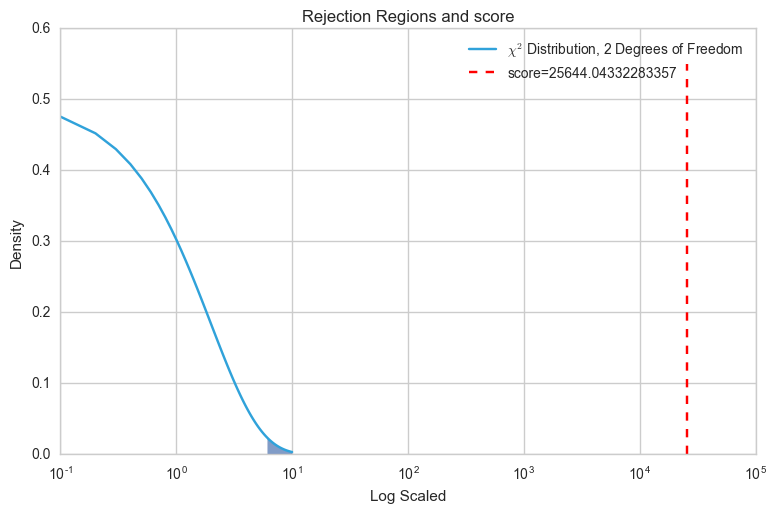

In [308]:
# JB test for normality for SPY log returns
jb_stat, p_values, skew, kurtosis = jarque_bera(SPY_returns)
cutoff = 0.05

if p_value < cutoff:
    print('With a JB stat of {0} and p={1}<{2}, we reject the null hypothesis'.format(jb_stat, p_value, cutoff))
else:
    print('With a JB stat of {0} and p={1}>{2}, we fail to reject the null hypothesis'.format(jb_stat, p_value, cutoff))
    
visualize_chi_squared(jb_stat, cutoff, dof=2)

With a JB stat of 25644.04332283357 and p=4.265739197263299e-35<0.05, we reject the null hypothesis


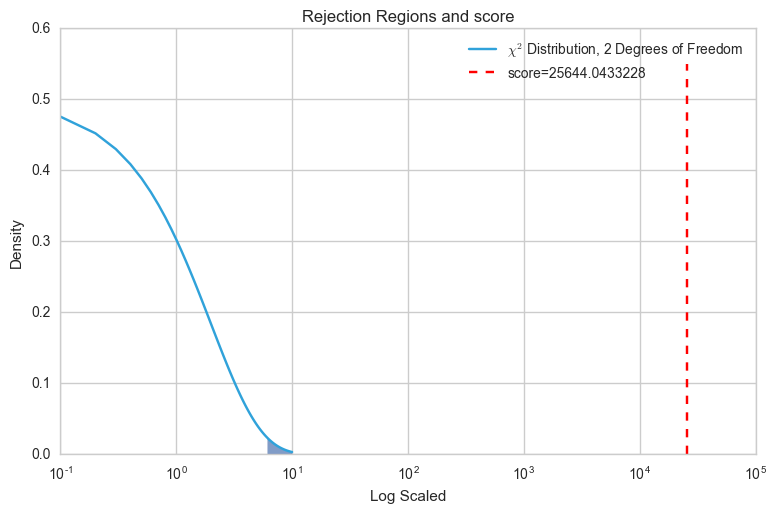

In [309]:
# JB test for normality for sec_3 log returns
jb_stat, p_values = stats.jarque_bera(SPY_returns)
cutoff = 0.05

if p_value < cutoff:
    print('With a JB stat of {0} and p={1}<{2}, we reject the null hypothesis'.format(jb_stat, p_value, cutoff))
else:
    print('With a JB stat of {0} and p={1}>{2}, we fail to reject the null hypothesis'.format(jb_stat, p_value, cutoff))
    
visualize_chi_squared(jb_stat, cutoff, dof=2)

# This analysis will continue in the notebook for part 2.